In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

import os
import pathlib
import time
import gc

IMG_SIZE = (200, 200)
INPUT_SIZE = tuple(list(IMG_SIZE) + [3])
# gc.collect()

In [0]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2019-07-20 13:16:09--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar.2’

images.tar.2         17%[==>                 ] 134.18M  47.0MB/s               ^C


In [0]:
!tar -xf images.tar

In [0]:
!ls "./"
dataFolder = "./Images/"

drive  Images  images.tar  sample_data


In [0]:
from google.colab import drive
drive.mount("drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
!ls "./"
mydrive = "./drive/My Drive/colab_data/dog_breed/"
dataFiles = [mydrive + "data/" + file for file in ("train.csv", "test.csv")]

drive  Images  images.tar  sample_data


# 1. Stratified split the images into train and test.

In [0]:
#----------------------------------------------------------------------------
class Prepare_train_test:
  """
  Make the correspondance between the images and labels (breeds of dogs),
  and stratified split the data into train and test parts.
  """
  def __init__(self, data_root, test_size, random_seed=42, saveFiles=None):
    """
    Then files in "data_root" will be stratified split into train and test parts.
    
    # Arguments
      -"data_root": the folder name of the images of dogs.
      -"test_size": the ratio of the test size to the total size.
      -"loadFiles=None": 
        list of the files for train and test DataFrames(df), [train.csv, test.csv]. 
        If it is None, the two dfs would be made from "data_root".
      -"saveFiles=None": 
        the list of file names (including path) to save train and test dfs 
        if it is given and "loadFiles==None". 
        If "loadFiles" is not None, this argument plays no role. 
    """
    self.data_root = pathlib.Path(data_root)

    # dictionary of breeds and labels
    breeds = [item.name for item in self.data_root.iterdir()]
    breeds.sort()
    # the correspondance between the breeds and labels
    self.breeds_labels = dict((item,i) for (i, item) in enumerate(breeds))
    self.breeds = breeds # list of breeds 
    
    images_labels = [[str(image), image.parent.name, self.breeds_labels[image.parent.name], ] 
                     for image in self.data_root.glob("*/*.jpg")]
    # labels = np.array([self.breeds_labels[image] for image in images])
    images_lables = pd.DataFrame(images_labels, columns=["image", "breed", "label"])

    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_seed)
    # stratified split
    for train_index, test_index in split.split(images_lables, images_lables["label"]):
      self.train = images_lables.loc[train_index] 
      self.test = images_lables.loc[test_index]
    
    # save
    if saveFiles:
      self.train.to_csv(saveFiles[0], index=None)
      self.test.to_csv(saveFiles[1], index=None)

    # load images
    # print("Load images")
    # self.load_images()
    
  def load_images(self):
    """
    load and convert the images into np.array.
    !!!Do not run it. Otherwise RAM will collapse!
    """
    x_list = []
    for df in (self.train, self.test):
      #images = [img_to_array(load_img(image_file, target_size=IMG_SIZE))/255. for image_file in df.iloc[:,0]]
      #images = np.stack(images, axis=0)
      
      print(len(df))
      
      # first image
      images = np.expand_dims(img_to_array(load_img(df.iloc[0,0], target_size=IMG_SIZE))/255., axis=0)
      # other image
      for i in range(1, len(df)):
        if i%1000 == 0: print(i)
        temp = np.expand_dims(img_to_array(load_img(df.iloc[i,0], target_size=IMG_SIZE))/255., axis=0)
        images = np.vstack((images, temp))
            
      x_list.append(images)
    
    # get the arrays of images
    self.x_train, self.x_test = x_list
    # get the labels
    self.y_train = self.train.iloc[:, 2].values
    self.y_train = self.test.values[:, 2].values

#----------------------------------------------------------------------------
class Load_train_test:
  """
  Load the train and test data 
  """
  def __init__(self, files):
    """
    Load the data from "files".
    
    # Arguments
      -"files": the list of the files of train and test data, [train.csv, test.csv]
        And each file should include three columns, ["image", "breed", "label"].
    """
    self.train = pd.read_csv(files[0], index_col=None)
    self.test = pd.read_csv(files[1], index_col=None)
    self.breeds_labels = dict(self.train.groupby(["breed", "label"]).groups.keys())
    self.breeds = list(self.breeds_labels.keys())
    self.breeds.sort(key = lambda x: self.breeds_labels[x])

## 1.1  Train and test images data

In [0]:
# Make the train and test data
# images_labels = Prepare_train_test(dataFolder, 0.1, saveFiles=dataFiles)
# load the trian and test data
images_labels = Load_train_test(files=dataFiles)

## 1.2 Explore data

In [0]:
print(images_labels.train.iloc[0,0])
print(images_labels.train.iloc[0,1])
print(images_labels.train.iloc[0,2])
print(images_labels.breeds[104])

Images/n02111277-Newfoundland/n02111277_5956.jpg
n02111277-Newfoundland
104
n02111277-Newfoundland


In [0]:
images_labels.train.head()

,image,breed,label
0,Images/n02111277-Newfoundland/n02111277_5956.jpg,n02111277-Newfoundland,104
1,Images/n02110185-Siberian_husky/n02110185_1338...,n02110185-Siberian_husky,99
2,Images/n02095570-Lakeland_terrier/n02095570_53...,n02095570-Lakeland_terrier,38
3,Images/n02093428-American_Staffordshire_terrie...,n02093428-American_Staffordshire_terrier,29
4,Images/n02087394-Rhodesian_ridgeback/n02087394...,n02087394-Rhodesian_ridgeback,8


In [0]:
print(images_labels.test.iloc[0,0])
print(images_labels.test.iloc[0,1])
print(images_labels.test.iloc[0,2])
print(images_labels.breeds[75])

Images/n02105251-briard/n02105251_8570.jpg
n02105251-briard
75
n02105251-briard


In [0]:
images_labels.test.head()

,image,breed,label
0,Images/n02105251-briard/n02105251_8570.jpg,n02105251-briard,75
1,Images/n02089078-black-and-tan_coonhound/n0208...,n02089078-black-and-tan_coonhound,14
2,Images/n02097658-silky_terrier/n02097658_8767.jpg,n02097658-silky_terrier,50
3,Images/n02102318-cocker_spaniel/n02102318_2984...,n02102318-cocker_spaniel,68
4,Images/n02110958-pug/n02110958_14768.jpg,n02110958-pug,102


In [0]:
images_labels.train.describe()

,label
count,18522.000000
mean,58.519922
std,35.166315
min,0.000000
25%,28.000000
50%,57.000000
75%,90.000000
max,119.000000


In [0]:
images_labels.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18522 entries, 0 to 18521
Data columns (total 3 columns):
image    18522 non-null object
breed    18522 non-null object
label    18522 non-null int64
dtypes: int64(1), object(2)
memory usage: 434.2+ KB


In [0]:
train_value_counts = images_labels.train["label"].value_counts()
train_value_counts.describe()

count    120.00000
mean     154.35000
std       20.87685
min      133.00000
25%      137.75000
50%      143.50000
75%      167.25000
max      227.00000
Name: label, dtype: float64

In [0]:
images_labels.test.describe()

,label
count,2058.000000
mean,58.583576
std,35.202644
min,0.000000
25%,28.000000
50%,57.000000
75%,90.000000
max,119.000000


In [0]:
images_labels.test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 3 columns):
image    2058 non-null object
breed    2058 non-null object
label    2058 non-null int64
dtypes: int64(1), object(2)
memory usage: 48.3+ KB


In [0]:
test_value_counts = images_labels.test["label"].value_counts()
test_value_counts.describe()

count    120.000000
mean      17.150000
std        2.360921
min       15.000000
25%       15.000000
50%       16.000000
75%       19.000000
max       25.000000
Name: label, dtype: float64

In [0]:
len(images_labels.breeds_labels.keys())

120

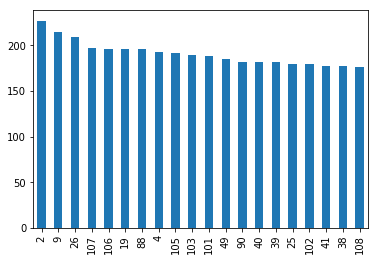

In [0]:
train_value_counts[:20].plot(kind="bar")

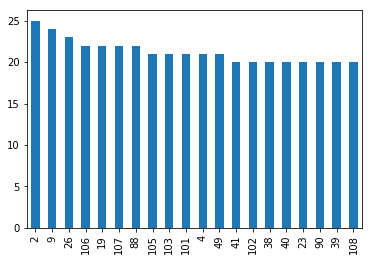

In [0]:
test_value_counts[:20].plot(kind="bar")

In [0]:
# check the stratified split
(train_value_counts/test_value_counts).describe()

count    120.000000
mean       9.004411
std        0.158234
min        8.687500
25%        8.893275
50%        9.000000
75%        9.117647
max        9.333333
Name: label, dtype: float64

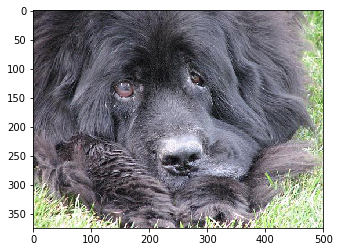

In [0]:
imag = load_img(images_labels.train.iloc[0,0])
imag = img_to_array(imag)
plt.imshow(imag/255)

#2. ImageDataGenerator

In [0]:
# generator for train and validation data
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=40, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             channel_shift_range=10,
                             horizontal_flip=True, 
                             validation_split=0.1)
# generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

## 2.1 visualize output of the generator

In [0]:
imag = load_img(images_labels.train.iloc[10,0])
imag = img_to_array(imag)

In [0]:
print(imag.shape)
imag_x = np.expand_dims(imag, axis=0)
print(imag_x.shape)
check_gen = datagen.flow(imag_x, batch_size=1)

(314, 349, 3)
(1, 314, 349, 3)


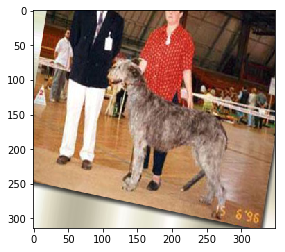

In [0]:
plt.imshow(next(check_gen)[0])

## 2.2 Data generators (train, validation, test)

In [0]:
BATCH_SIZE_train = 500
# BATCH_SIZE_train = 300
BATCH_SIZE_val = 98
BATCH_SIZE_test = 42

train_generator = datagen.flow_from_dataframe(dataframe=images_labels.train, x_col="image", y_col="breed", 
                                              subset="training", 
                                              classes=images_labels.breeds, 
                                              class_mode="sparse", 
                                              batch_size=BATCH_SIZE_train, 
                                              target_size=IMG_SIZE)
val_generator = datagen.flow_from_dataframe(dataframe=images_labels.train, x_col="image", y_col="breed", 
                                            subset="validation", 
                                            classes=images_labels.breeds, 
                                            class_mode="sparse", 
                                            batch_size=BATCH_SIZE_val, 
                                            target_size=IMG_SIZE)

test_generator = test_datagen.flow_from_dataframe(dataframe=images_labels.test, x_col="image", y_col="breed", 
                                                  classes=images_labels.breeds, 
                                                  class_mode="sparse", 
                                                  batch_size=BATCH_SIZE_test, 
                                                  target_size=IMG_SIZE, 
                                                  shuffle=False)

Found 16670 validated image filenames belonging to 120 classes.
Found 1852 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


In [0]:
for i, breed in enumerate(images_labels.breeds):
  if (train_generator.class_indices[breed] != i): 
    print("Wrong!")
    break
else:
  print("Yes!")

Yes!


In [0]:
for i, breed in enumerate(images_labels.breeds):
  if (val_generator.class_indices[breed] != i): 
    print("Wrong!")
    break
else:
  print("Yes!")

Yes!


# 3. Construct model


In [0]:
# function to construct model
def fModel_dog_breeds(base_model, flat_layers):
  """
  -"flat_layers": the list of units in the flat layers top of "base_model". 
    It should not incleude the output layer which is fixed to be 120.
  """
  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(layers.Flatten())
  for n_units in flat_layers:
    model.add(layers.Dense(units=n_units, activation="relu"))
    model.add(layers.Dropout(0.5))
  model.add(layers.Dense(120, activation="softmax"))
  
  return model


In [0]:
K.clear_session()
gc.collect()
from tensorflow.keras.applications import InceptionV3
conv_base = InceptionV3(include_top=False, weights="imagenet", input_shape=INPUT_SIZE)

W0720 13:18:08.559306 140672415815552 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model = fModel_dog_breeds(conv_base, [1204])
print("Number of trainalbe layers before freezing the base model:", len(model.trainable_weights))
conv_base.trainable = False
print("Number of trainalbe layers after freezing the base model:", len(model.trainable_weights))

Number of trainalbe layers before freezing the base model: 4
Number of trainalbe layers after freezing the base model: 4


## 3.1 One Cycle Policy

In [0]:
import math

class OneCyclePolicy(keras.callbacks.Callback):
  """
  To implement the one cycle policy to find a good learning rate.
  """
  def __init__(self, init_lr, final_lr, num, beta=0.98):
    """
    -"init_lr": the initial learning rate to tested
    -"final_lr": the final learning rate to tested
    -"num": the number of learing rates to be tested. 
      Usually, it should be "len(train_data)/batch_size" or "steps_per_epoch". 
    """
    # call the super init
    keras.callbacks.Callback.__init__(self)
    self.init_lr, self.final_lr, self.num, self.beta = init_lr, final_lr, num, beta
    
    # calculate the multiplication factor
    self.mult = (self.final_lr/self.init_lr)**(1./self.num)
    
    self.losses = []
    self.log_lrs = []
    self.best_loss = None
    self.avg_loss = 0
    
  def on_train_begin(self, logs={}):
    # set the inital learning rate
    K.set_value(self.model.optimizer.lr, self.init_lr)
  
  def on_train_batch_end(self, batch, logs={}):
    
    # get the average loss
    current = logs.get("loss")
    # update the average loss
    self.avg_loss = self.beta*self.avg_loss + (1-self.beta)*current
    # get the smoothed (bias corrrected) loss 
    smoothed  = self.avg_loss/(1 - self.beta**(batch+1))
    
    # update the best loss
    if self.best_loss is None or self.best_loss > smoothed:
      self.best_loss = smoothed

    if 2*self.best_loss < smoothed :
      self.model.stop_training = True
    else:
      # append the smoothed loss and the log lr
      self.losses.append(smoothed)
      # append log10 lr
      lr = K.get_value(self.model.optimizer.lr)
      self.log_lrs.append(math.log10(lr))
      # update lr
      K.set_value(self.model.optimizer.lr, lr*self.mult)


In [0]:
model.compile(optimizer = keras.optimizers.RMSprop(lr=1.0), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
find_lr = OneCyclePolicy(1e-7, 1e-3, train_generator.n//BATCH_SIZE_train)
history = model.fit_generator(train_generator, epochs=1, steps_per_epoch=train_generator.n//BATCH_SIZE_train,
                              callbacks=[find_lr])

33/33 [==============================] - 202s 6s/step - loss: 5.6442 - acc: 0.0151


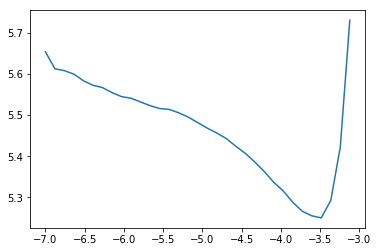

In [0]:
n=33
plt.plot(find_lr.log_lrs[:n], find_lr.losses[:n])
plt.show()

## 3.2 Train and test

In [0]:
EPOCHS = 40
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
# checkpoints
modelFolder = "./models/"
bestModelFile = modelFolder + "weights.epoch:{epoch:02d}-val_acc:{val_acc:2f}.h5"

checkpoint_bestmodel = ModelCheckpoint(bestModelFile, monitor="val_acc", save_weight_only=True, save_best_only=True)


# checkpoint_finalmodel = LambdaCallback(on_train_end=lambda logs: 
#                                       model.save_weights(bestModelFile.format(epoch=EPOCHS, val_acc=logs["val_acc"])))

callback_list = [checkpoint_bestmodel]

In [0]:
!mkdir "./models"
!ls 

drive  Images  images.tar  models  sample_data


In [0]:
# learning_rate = 1e-4
learning_rate = 2e-5

model.compile(optimizer = keras.optimizers.RMSprop(lr=learning_rate), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Number of trainalbe layers before freezing the base model: 192
Number of trainalbe layers after freezing the base model: 4


In [0]:
history = model.fit_generator(train_generator, epochs=EPOCHS, steps_per_epoch=train_generator.n//BATCH_SIZE_train, validation_data=val_generator, 
                              validation_steps=val_generator.n//BATCH_SIZE_val, callbacks=callback_list )
finalModel = bestModelFile.format(epoch=EPOCHS, val_acc=history.history["val_acc"][-1])
if not os.path.exists(finalModel):
  model.save_weights(finalModel)

Epoch 1/40
33/33 [==============================] - 213s 6s/step - loss: 4.7079 - acc: 0.0477 - val_loss: 3.1686 - val_acc: 0.3016
Epoch 2/40
33/33 [==============================] - 197s 6s/step - loss: 4.1294 - acc: 0.1387 - val_loss: 2.1854 - val_acc: 0.4620
Epoch 3/40
33/33 [==============================] - 196s 6s/step - loss: 3.6952 - acc: 0.2055 - val_loss: 1.9793 - val_acc: 0.5210
Epoch 4/40
33/33 [==============================] - 194s 6s/step - loss: 3.4186 - acc: 0.2525 - val_loss: 1.9106 - val_acc: 0.5323
Epoch 5/40
33/33 [==============================] - 191s 6s/step - loss: 3.2189 - acc: 0.2792 - val_loss: 1.9188 - val_acc: 0.5646
Epoch 6/40
33/33 [==============================] - 193s 6s/step - loss: 3.0823 - acc: 0.3008 - val_loss: 1.8908 - val_acc: 0.5669
Epoch 7/40
33/33 [==============================] - 188s 6s/step - loss: 3.0107 - acc: 0.3157 - val_loss: 1.9647 - val_acc: 0.5680
Epoch 8/40
33/33 [==============================] - 190s 6s/step - loss: 2.9078 - a

In [0]:
test_generator.reset()
model.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE_test)

[1.462571181813065, 0.7176871]

In [0]:
history = model.fit_generator(train_generator, epochs=1, steps_per_epoch=train_generator.n//BATCH_SIZE_train, validation_data=val_generator, 
                              validation_steps=val_generator.n//BATCH_SIZE_val, callbacks=callback_list )
finalModel = bestModelFile.format(epoch=EPOCHS, val_acc=history.history["val_acc"][-1])
if not os.path.exists(finalModel):
  model.save_weights(finalModel)

33/33 [==============================] - 201s 6s/step - loss: 2.0612 - acc: 0.4797 - val_loss: 2.0571 - val_acc: 0.6037


In [0]:
test_generator.reset()
model.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE_test)

[1.460642829841497, 0.72206026]

In [0]:
# model1 = keras.models.load_model("models/weights.epoch:04-val_acc:0.603175.h5")
model2 = keras.models.load_model("drive/My Drive/colab_data/dog_breed/models/weights.epoch:45-val_acc:0.599206.h5")

In [0]:
test_generator.reset()
model2.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE_test)

[1.4624003731474584, 0.7201166]

In [0]:
!ls "models/"

ls: cannot access 'models/': No such file or directory


In [0]:
!cp models/weights.epoch:04-val_acc:0.603175.h5 "./drive/My Drive/colab_data/dog_breed/models/"

In [0]:
model

In [0]:
finalModel = bestModelFile.format(epoch=EPOCHS, val_acc=history.history["val_acc"][-1])
if not os.path.exists(finalModel):
  model.save_weights(finalModel)

In [0]:
!cp "./models/weights.epoch:40-val_acc:0.595805.h5" "./drive/My Drive/colab_data/dog_breed/models/"
!cp "./models/weights.epoch:34-val_acc:0.608277.h5" "./drive/My Drive/colab_data/dog_breed/models/"

In [0]:
print(mydrive)
#!cp "./models/weights.epoch:04-val_acc:0.587868.h5" "./drive/My Drive/colab_data/dog_breed/models/"
!cp -r "./models/" "./drive/My Drive/colab_data/dog_breed/models/"
!ls "./drive/My Drive/colab_data/dog_breed/models/"

./drive/My Drive/colab_data/dog_breed/
models	weights.epoch:04-val_acc:0.587868.h5


In [0]:
print(type(history.history["loss"]))
print(len(history.history["loss"]))
history.history["loss"][0:10]

<class 'list'>
20


[4.075139048074452,
 2.9181255862236615,
 2.617769850575784,
 2.506754972644256,
 2.3825345857687474,
 2.3278877002336245,
 2.2531248976141858,
 2.1861121048511514,
 2.1047256292202774,
 2.0464073831679723]

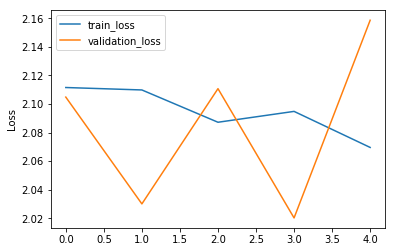

In [0]:
x_range = list(range(0, len(history.history["loss"])))
plt.plot(x_range, history.history["loss"], label="train_loss")
# plt.plot(range(10), label="train_loss")
plt.plot(history.history["val_loss"], label="validation_loss")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
!ls -lh "dog_breeds/model"

total 386M
-rw-r--r-- 1 root root 386M Jul 14 10:30 model_train_0.5396_val_0.5822.h5


In [0]:
print(history.history.keys())
history_df = pd.DataFrame(history.history)
history_df.columns=['train_loss', 'train_acc', 'val_loss', 'val_acc']

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


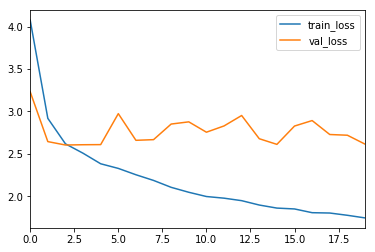

In [0]:
history_df.plot(y=["train_loss", "val_loss"])

In [0]:
print(history_df.shape)
history_df.describe()

(20, 4)


,val_loss,val_acc
count,20.000000,20.000000
mean,2.766354,0.559807
std,0.163485,0.028615
min,2.603802,0.452381
25%,2.636491,0.556548
50%,2.723434,0.564909
75%,2.857495,0.572846
max,3.230802,0.584467
